# install necessary lib

In [172]:
!pip install -r requirements.txt

You should consider upgrading via the '/Users/jirayuwat/Desktop/GAN-indiv-study/env/bin/python3 -m pip install --upgrade pip' command.


# import lib

In [197]:
import torch
from torch import nn

from torchsummary import summary
from torchvision import transforms, datasets

from tqdm import tqdm

import matplotlib.pyplot as plt

import random

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# load data

- load as data loader 
- batch size = 128
- image pixel value [0,1]
- only 1 channel

In [174]:
SEED = 1
BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
torch.manual_seed(SEED)
train_loader = torch.utils.data.DataLoader (datasets.MNIST('dataset/', 
                                                           train=True, 
                                                           download=True,
                                                           transform= transforms.Compose([transforms.ToTensor()])
                                                           ),
                                            batch_size = BATCH_SIZE, 
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('dataset/', 
                                                         train=False, 
                                                         transform=transforms.Compose([transforms.ToTensor()])
                                                        ), 
                                          batch_size = TEST_BATCH_SIZE, 
                                          shuffle=True)

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(0.9961)
tensor(0.) tensor(1.)


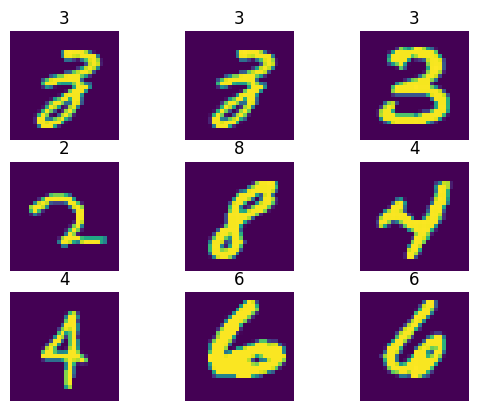

In [175]:
img, label = next(iter(train_loader))
import random
for i in range(9):
    idx = random.randint(0,63)
    plt.subplot(3, 3, i+1)
    plt.imshow(img[idx].reshape(28,28,1))
    plt.axis('off')
    plt.title(label[idx].item())
    print(torch.min(img[idx]), torch.max(img[idx]))


# Train controller

In [199]:
TRAIN_AE = False

# create AE model
- latent = 20d
- 60 epoch
- optimizer = Adam
- loss = MSE
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
           Flatten-1                  [-1, 784]               0
              ReLU-2                  [-1, 784]               0
            Linear-3                 [-1, 1000]         785,000
              ReLU-4                 [-1, 1000]               0
            Linear-5                 [-1, 1000]       1,001,000
              ReLU-6                 [-1, 1000]               0
            Linear-7                 [-1, 1000]       1,001,000
              ReLU-8                 [-1, 1000]               0
            Linear-9                   [-1, 20]          20,020
           Linear-10                 [-1, 1000]          21,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                 [-1, 1000]       1,001,000
             ReLU-13                 [-1, 1000]               0
           Linear-14                 [-1, 1000]       1,001,000
             ReLU-15                 [-1, 1000]               0
           Linear-16                  [-1, 784]         784,784
             ReLU-17                  [-1, 784]               0
        Unflatten-18            [-1, 1, 28, 28]               0
          Sigmoid-19            [-1, 1, 28, 28]               0
================================================================
Total params: 5,614,804
```
![result image](./AE_60epochs_20d-latent.png)

In [202]:
LATENT_SIZE = 20
IMAGE_SIZE = (1, 28, 28)

In [203]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

class AE_model(nn.Module):
    
    def __init__(self, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(IMAGE_SIZE[0] * IMAGE_SIZE[1] * IMAGE_SIZE[2], 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, latent_size)
        ).to(DEVICE)
        self.encoder.apply(init_weights)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, IMAGE_SIZE[0] * IMAGE_SIZE[1] * IMAGE_SIZE[2]),
            nn.ReLU(),
            nn.Unflatten(1, IMAGE_SIZE),
            nn.Sigmoid(),
        ).to(DEVICE)
        self.decoder.apply(init_weights)
    
    def forward(self, x_in):
        
        x_in = self.encoder(x_in)
        x_in = self.decoder(x_in)

        return x_in
    
summary(AE_model(LATENT_SIZE), IMAGE_SIZE)

ae_model = AE_model(LATENT_SIZE).to(DEVICE)
ae_loss_fn = nn.MSELoss()

ae_optimizer = torch.optim.Adam(params=ae_model.parameters(), lr = 5e-5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
              ReLU-2                  [-1, 784]               0
            Linear-3                 [-1, 1000]         785,000
              ReLU-4                 [-1, 1000]               0
            Linear-5                 [-1, 1000]       1,001,000
              ReLU-6                 [-1, 1000]               0
            Linear-7                 [-1, 1000]       1,001,000
              ReLU-8                 [-1, 1000]               0
            Linear-9                   [-1, 20]          20,020
           Linear-10                 [-1, 1000]          21,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                 [-1, 1000]       1,001,000
             ReLU-13                 [-1, 1000]               0
           Linear-14                 [-

/var/folders/5g/160h3py942nb4pbbgy0dhtz40000gn/T/ipykernel_27043/3606350680.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


## train model

In [200]:
EPOCHS = 60 if TRAIN_AE else 0

for epoch in range(EPOCHS):
    epoch += 1
    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(DEVICE)
        y_train = y_train.to(DEVICE)
        
        ae_model.train()
        x_pred = ae_model(x_train)
        loss = ae_loss_fn(x_pred, x_train)
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        ae_model.eval()
        with torch.inference_mode():
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}/{EPOCHS}({batch_idx})\t: Loss = {loss.item()}')
                


Epoch: 1/1(0)	: Loss = 0.23461632430553436
Epoch: 1/1(10)	: Loss = 0.2313583940267563
Epoch: 1/1(20)	: Loss = 0.2309824824333191
Epoch: 1/1(30)	: Loss = 0.23133769631385803
Epoch: 1/1(40)	: Loss = 0.23143567144870758
Epoch: 1/1(50)	: Loss = 0.2312895655632019
Epoch: 1/1(60)	: Loss = 0.2318798303604126
Epoch: 1/1(70)	: Loss = 0.23089054226875305
Epoch: 1/1(80)	: Loss = 0.23071907460689545
Epoch: 1/1(90)	: Loss = 0.23156437277793884
Epoch: 1/1(100)	: Loss = 0.23130226135253906
Epoch: 1/1(110)	: Loss = 0.2307811826467514
Epoch: 1/1(120)	: Loss = 0.23066146671772003
Epoch: 1/1(130)	: Loss = 0.23029601573944092
Epoch: 1/1(140)	: Loss = 0.22952806949615479
Epoch: 1/1(150)	: Loss = 0.22992998361587524
Epoch: 1/1(160)	: Loss = 0.22945727407932281
Epoch: 1/1(170)	: Loss = 0.23069357872009277
Epoch: 1/1(180)	: Loss = 0.22966593503952026
Epoch: 1/1(190)	: Loss = 0.22931908071041107
Epoch: 1/1(200)	: Loss = 0.22990892827510834
Epoch: 1/1(210)	: Loss = 0.22961211204528809
Epoch: 1/1(220)	: Loss = 0

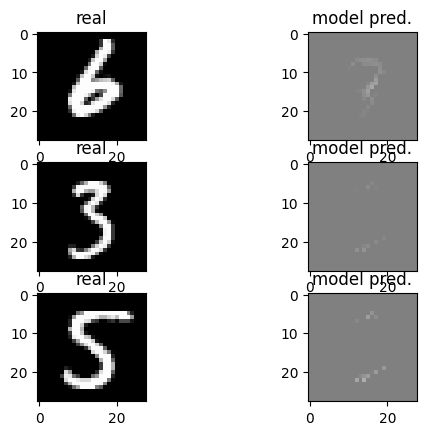

In [201]:
img, _ = next(iter(train_loader))
img = img.to(DEVICE)

for i in range(3):
    idx = random.randint(0, BATCH_SIZE - 1)
    x_pred = ae_model(img[idx]).to('cpu').detach().numpy().reshape((28, 28, 1))
    plt.subplot(3, 2, i*2 + 1)
    plt.title('real')
    plt.imshow(img[idx].to('cpu').reshape(28, 28, 1), vmin=0, vmax=1, cmap='gray')
    plt.subplot(3, 2, i*2 + 2)
    plt.title('model pred.')
    plt.imshow(x_pred, vmin=0, vmax=1, cmap='gray')


# create VAE model

- ref vdo : [youtube](https://www.youtube.com/watch?v=VELQT1-hILo)
- ref paper : [arxiv](https://arxiv.org/abs/1312.6114)
